In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

from scipy.sparse import hstack, vstack, csr_matrix
from scipy import sparse

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Embedding, GRU
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.layers.normalization import BatchNormalization
from keras_tqdm import TQDMNotebookCallback, TQDMCallback


from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.svm import SVC, LinearSVC, NuSVC

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif, chi2, SelectFromModel

from sklearn import preprocessing
from sklearn.decomposition import PCA, SparsePCA

import gensim
from gensim.models import Word2Vec

import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

from multiprocessing import Pool
from importlib import reload

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [2]:
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt

#font = {'family': 'Verdana', 'weight': 'normal'}
#rc('font', **font)
matplotlib.style.use('ggplot')

%matplotlib inline

pd.set_option('display.max_rows', 15)

In [3]:
#spacy.util.set_data_path('/home/data/spacy/en-1.1.0')
#spacy.util.set_data_path('/home/data/spacy/en_glove_cc_300_1m_vectors-1.0.0')
spacy.util.set_data_path('/home/data/spacy/')
nlp = spacy.load('en')

# Загрузка данных

In [4]:
train_set = pd.read_table('/home/data/shad-yelp-sentiment-analysis/train.data', index_col=0)
test_set = pd.read_table('/home/data/shad-yelp-sentiment-analysis/test.data', index_col=0)

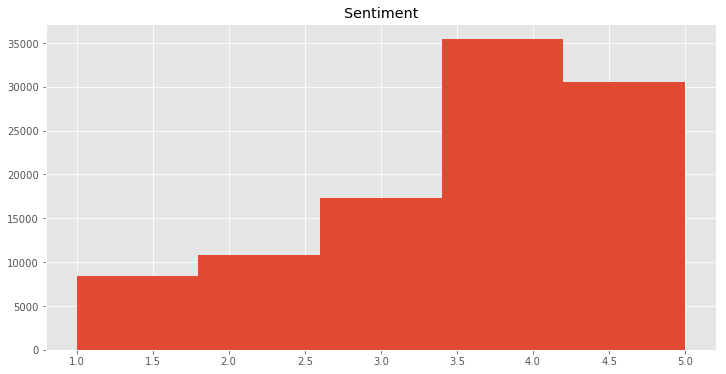

In [5]:
train_set.hist(column='Sentiment', bins=5, figsize=(12, 6))
plt.show()

In [6]:
Y_train = train_set['Sentiment']
Y_train_categorical = np_utils.to_categorical(Y_train)[:, 1:]

In [7]:
Y_train_counts = train_set['Sentiment'].value_counts()[[1, 2, 3, 4, 5]]
Y_train_counts

1     8457
2    10798
3    17340
4    35432
5    30517
Name: Sentiment, dtype: int64

In [8]:
Y_train_percents = Y_train_counts/Y_train.size
Y_train_percents = Y_train_percents.values
Y_train_percents

array([ 0.08247191,  0.10530114,  0.16909814,  0.34552972,  0.29759908])

# Tokenization

## Spacy.io

### Text Preparation

In [9]:
def remove_character_from_string(s, old_characters_list=['\n', '\t'], new_characters_list=None):
    if not new_characters_list:
        new_characters_list = [' ']*len(old_characters_list)
        
    for old_c, new_c in zip(old_characters_list, new_characters_list):
        s = s.replace(old_c, new_c)
        
    return s

def remove_extra_spaces(s):
    return ' '.join( s.split() )

In [10]:
money_regex = r'\$[0-9.,]+'

def money_regex_replace(s):
    return re.sub(money_regex, ' money_regex ', s)

In [11]:
dots_regex = r'\.[.]+'

def dots_replace(s):
    return re.sub(dots_regex, ' ... ', s)

In [12]:
def clear_string(s, to_lower=True):
    s = remove_character_from_string(s, 
                                     ['\\n', '\\"', '-', '"', "\\", ')', '(', '/'], 
                                     [' ', ' ', ' - ', ' ', '', ' ) ', ' ( ', ' / '])
    s = money_regex_replace(s)
    s = dots_replace(s)
    s = remove_extra_spaces(s)
    s = s.lower() if to_lower else s
    return s

### Tokenization

In [13]:
def get_spacy_tokens_objects(s):
    s = clear_string(s, to_lower=False)
    return nlp(s)

if 1==0:
    train_tokenized_objects = train_set['Text'].apply(get_spacy_tokens_objects)
    test_tokenized_objects = test_set['Text'].apply(get_spacy_tokens_objects)

In [14]:
def text_from_spacy_tokens(tokens):
    tokens = [token.lower_ for token in tokens]
    #tokens = [token.lemma_ if not ((token.is_oov) or (token.lemma_ == '-PRON-')) else token.lower_ for token in tokens]
    return ' '.join(tokens)

if 1==0:
    train_tokenized = train_tokenized_objects.apply(text_from_spacy_tokens)
    test_tokenized = test_tokenized_objects.apply(text_from_spacy_tokens)

In [15]:
method = 'load'

if method == 'store':
    train_tokenized.to_csv('train_tokenized_lemma.csv', index='Id', header=['Sentiment'])
    test_tokenized.to_csv('test_tokenized_lemma.csv', index='Id', header=['Sentiment'])
    
if method == 'load':
    train_tokenized = pd.read_csv('train_tokenized_lemma.csv', index_col='Id', header=0)
    test_tokenized = pd.read_csv('test_tokenized_lemma.csv', index_col='Id', header=0)
    
    train_tokenized = train_tokenized['Sentiment']
    test_tokenized = test_tokenized['Sentiment']

In [16]:
def space_tokenizer(s):
    return s.split(' ')

# Множества(train, test, validation)

In [17]:
train_tokenz, validation_tokenz, y_train, y_validation = train_test_split(train_tokenized.values, Y_train.values,
                                                                          test_size=0.1, random_state=42)
test_tokenz = test_tokenized.values

# Features

## TFOR

In [18]:
from stw import tfor
reload(tfor);

In [24]:
def space_tokenizer(s):
    return s.split(' ')

vectorizer = CountVectorizer(analyzer="word", lowercase=False, tokenizer=space_tokenizer,
                             min_df=20, ngram_range=(1, 3), binary=False)

vectorizer = vectorizer.fit(train_tokenz)

train_counts = vectorizer.transform(train_tokenz)
validation_counts = vectorizer.transform(validation_tokenz)
test_counts = vectorizer.transform(test_tokenz)

In [25]:
train_counts_weighted, validation_counts_weighted, test_counts_weighted = [], [], []
for mark in range(1, 6):
    transformer = tfor.TforTransformer(norm='l2', sublinear_tf=False)
    
    counts_for_train = transformer.fit_transform(train_counts, y_train==mark)
    counts_for_validation = transformer.transform(validation_counts)
    counts_for_test = transformer.transform(test_counts)
    
    train_counts_weighted.append(counts_for_train)
    validation_counts_weighted.append(counts_for_validation)
    test_counts_weighted.append(counts_for_test)

In [27]:
x_train, x_test = hstack(train_counts_weighted, format='csr'), hstack(test_counts_weighted, format='csr')
x_validation = hstack(validation_counts_weighted, format='csr')

## Features Selection

### LogisticRegression SelectFromModel

In [28]:
logreg = LogisticRegression(penalty='l2', max_iter=100, n_jobs=8)
logreg = logreg.fit(x_train, y_train)

accuracy_score(logreg.predict(x_validation), y_validation)

0.62584105314480742

In [29]:
features_selector = SelectFromModel(logreg, threshold='1.40*mean')
features_selector = features_selector.fit(x_train, y_train)

In [30]:
x_train_filtred = features_selector.transform(x_train)
x_validation_filtred = features_selector.transform(x_validation)
x_test_filtred = features_selector.transform(x_test)

In [31]:
logreg_test = LogisticRegression(penalty='l2', max_iter=100, n_jobs=8)
logreg_test = logreg_test.fit(x_train_filtred, y_train)

accuracy_score(logreg_test.predict(x_validation_filtred), y_validation)

0.62652364700146268

In [32]:
x_train.shape[1], x_train_filtred.shape[1]

(1006175, 239273)

# Models

## NN

### batch_generator

In [33]:
def batch_generator(X, Y, batch_size, shuffle=False):
    number_of_batches, counter, shuffle_index = X.shape[0]//batch_size, 0, np.arange(Y.shape[0])
    
    if shuffle:
        np.random.shuffle(shuffle_index)

    X, Y =  X[shuffle_index], Y[shuffle_index]
    
    while True:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch, Y_batch = X[index_batch], Y[index_batch]
        
        counter += 1
        yield X_batch.toarray(), Y_batch
        
        if counter == number_of_batches:
            if shuffle:
                np.random.shuffle(shuffle_index)
            counter=0

### model architecture

In [34]:
def get_nn_model(*, path_to_hdf5=False, input_dim=None):
    # Create model
    model = Sequential()   
    model.add(Dropout(0.5, input_shape=input_dim))
    model.add(Dense(25, activation='sigmoid', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax', kernel_initializer='he_normal'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # load pretrained weights
    if path_to_hdf5:
        model.load_weights(path_to_hdf5)

    print(model.summary())
    return model

filepath="weights_{epoch:02d}_{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=25, mode='max')
callbacks_list = [checkpoint, early_stopping, TQDMNotebookCallback()]

### training

In [35]:
batch_size = 64
steps_per_epoch = 200#batch_size*(x_train_filtred.shape[0] // batch_size)
validation_steps = 200#batch_size*(x_validation_filtred.shape[0] // batch_size)
input_dim = (batch_size, x_train.shape[1])
input_dim = (x_train.shape[1], )

y_train_categorical = np_utils.to_categorical(y_train)[:, 1:]
y_validation_categorical = np_utils.to_categorical(y_validation)[:, 1:]

model = get_nn_model(input_dim=input_dim)
history = model.fit_generator(generator=batch_generator(x_train, y_train_categorical, batch_size, shuffle=True),
                              steps_per_epoch=steps_per_epoch,
                              validation_data=batch_generator(x_validation, y_validation_categorical,
                                                              batch_size, shuffle=False),
                              validation_steps=validation_steps,
                              epochs=1000, verbose=2, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 1006175)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                25154400  
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 130       
Total params: 25,154,530.0
Trainable params: 25,154,530.0
Non-trainable params: 0.0
_________________________________________________________________
None


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Epoch 1/1000
Epoch 00000: val_acc improved from -inf to 0.43742, saving model to weights_00_0.437.hdf5
123s - loss: 1.4997 - acc: 0.3377 - val_loss: 1.3278 - val_acc: 0.4374
Epoch 2/1000


The installed widget Javascript is the wrong version.


Epoch 00001: val_acc improved from 0.43742 to 0.48148, saving model to weights_01_0.481.hdf5
112s - loss: 1.3407 - acc: 0.3941 - val_loss: 1.2149 - val_acc: 0.4815
Epoch 3/1000


The installed widget Javascript is the wrong version.


Epoch 00002: val_acc improved from 0.48148 to 0.52344, saving model to weights_02_0.523.hdf5
116s - loss: 1.2334 - acc: 0.4461 - val_loss: 1.1227 - val_acc: 0.5234


The installed widget Javascript is the wrong version.


Epoch 4/1000
Epoch 00003: val_acc improved from 0.52344 to 0.55797, saving model to weights_03_0.558.hdf5
119s - loss: 1.1555 - acc: 0.4873 - val_loss: 1.0440 - val_acc: 0.5580
Epoch 5/1000


The installed widget Javascript is the wrong version.


Epoch 00004: val_acc improved from 0.55797 to 0.59461, saving model to weights_04_0.595.hdf5
114s - loss: 1.0944 - acc: 0.5065 - val_loss: 0.9871 - val_acc: 0.5946
Epoch 6/1000


The installed widget Javascript is the wrong version.


Epoch 00005: val_acc improved from 0.59461 to 0.60664, saving model to weights_05_0.607.hdf5
119s - loss: 1.0472 - acc: 0.5312 - val_loss: 0.9521 - val_acc: 0.6066


The installed widget Javascript is the wrong version.


Epoch 7/1000
Epoch 00006: val_acc improved from 0.60664 to 0.61273, saving model to weights_06_0.613.hdf5
119s - loss: 1.0274 - acc: 0.5394 - val_loss: 0.9221 - val_acc: 0.6127
Epoch 8/1000


The installed widget Javascript is the wrong version.


Epoch 00007: val_acc improved from 0.61273 to 0.61648, saving model to weights_07_0.616.hdf5
111s - loss: 0.9552 - acc: 0.5868 - val_loss: 0.8941 - val_acc: 0.6165
Epoch 9/1000


The installed widget Javascript is the wrong version.


Epoch 00008: val_acc improved from 0.61648 to 0.62266, saving model to weights_08_0.623.hdf5
119s - loss: 0.9306 - acc: 0.5968 - val_loss: 0.8800 - val_acc: 0.6227
Epoch 10/1000


The installed widget Javascript is the wrong version.


Epoch 00009: val_acc improved from 0.62266 to 0.62805, saving model to weights_09_0.628.hdf5


The installed widget Javascript is the wrong version.


117s - loss: 0.9185 - acc: 0.5964 - val_loss: 0.8653 - val_acc: 0.6280
Epoch 11/1000
Epoch 00010: val_acc improved from 0.62805 to 0.63375, saving model to weights_10_0.634.hdf5
113s - loss: 0.9035 - acc: 0.6010 - val_loss: 0.8540 - val_acc: 0.6338
Epoch 12/1000


The installed widget Javascript is the wrong version.


Epoch 00011: val_acc improved from 0.63375 to 0.63383, saving model to weights_11_0.634.hdf5
119s - loss: 0.8915 - acc: 0.6138 - val_loss: 0.8476 - val_acc: 0.6338


The installed widget Javascript is the wrong version.


Epoch 13/1000
Epoch 00012: val_acc improved from 0.63383 to 0.63578, saving model to weights_12_0.636.hdf5
113s - loss: 0.8876 - acc: 0.6105 - val_loss: 0.8391 - val_acc: 0.6358


The installed widget Javascript is the wrong version.


Epoch 14/1000
Epoch 00013: val_acc improved from 0.63578 to 0.64141, saving model to weights_13_0.641.hdf5


The installed widget Javascript is the wrong version.


116s - loss: 0.8804 - acc: 0.6084 - val_loss: 0.8349 - val_acc: 0.6414
Epoch 15/1000
Epoch 00014: val_acc did not improve
119s - loss: 0.8489 - acc: 0.6291 - val_loss: 0.8250 - val_acc: 0.6391
Epoch 16/1000


The installed widget Javascript is the wrong version.


Epoch 00015: val_acc did not improve
118s - loss: 0.8002 - acc: 0.6620 - val_loss: 0.8184 - val_acc: 0.6408
Epoch 17/1000


The installed widget Javascript is the wrong version.


Epoch 00016: val_acc improved from 0.64141 to 0.64172, saving model to weights_16_0.642.hdf5


The installed widget Javascript is the wrong version.


122s - loss: 0.8013 - acc: 0.6503 - val_loss: 0.8158 - val_acc: 0.6417
Epoch 18/1000
Epoch 00017: val_acc improved from 0.64172 to 0.64500, saving model to weights_17_0.645.hdf5
132s - loss: 0.7987 - acc: 0.6495 - val_loss: 0.8061 - val_acc: 0.6450
Epoch 19/1000


The installed widget Javascript is the wrong version.


Epoch 00018: val_acc improved from 0.64500 to 0.64609, saving model to weights_18_0.646.hdf5


The installed widget Javascript is the wrong version.


124s - loss: 0.7864 - acc: 0.6630 - val_loss: 0.8052 - val_acc: 0.6461
Epoch 20/1000
Epoch 00019: val_acc improved from 0.64609 to 0.64695, saving model to weights_19_0.647.hdf5
139s - loss: 0.7862 - acc: 0.6589 - val_loss: 0.8043 - val_acc: 0.6470
Epoch 21/1000


The installed widget Javascript is the wrong version.


Epoch 00020: val_acc improved from 0.64695 to 0.64719, saving model to weights_20_0.647.hdf5


The installed widget Javascript is the wrong version.


117s - loss: 0.7863 - acc: 0.6580 - val_loss: 0.8013 - val_acc: 0.6472
Epoch 22/1000
Epoch 00021: val_acc did not improve
120s - loss: 0.7570 - acc: 0.6792 - val_loss: 0.8029 - val_acc: 0.6445
Epoch 23/1000


The installed widget Javascript is the wrong version.


Epoch 00022: val_acc did not improve
119s - loss: 0.7100 - acc: 0.6944 - val_loss: 0.8016 - val_acc: 0.6454
Epoch 24/1000


The installed widget Javascript is the wrong version.


Epoch 00023: val_acc improved from 0.64719 to 0.64945, saving model to weights_23_0.649.hdf5
109s - loss: 0.7128 - acc: 0.6913 - val_loss: 0.7969 - val_acc: 0.6495
Epoch 25/1000


The installed widget Javascript is the wrong version.


Epoch 00024: val_acc did not improve
119s - loss: 0.7150 - acc: 0.6952 - val_loss: 0.7988 - val_acc: 0.6447
Epoch 26/1000


The installed widget Javascript is the wrong version.


Epoch 00025: val_acc did not improve
118s - loss: 0.7150 - acc: 0.6930 - val_loss: 0.7973 - val_acc: 0.6449
Epoch 27/1000


The installed widget Javascript is the wrong version.


Epoch 00026: val_acc improved from 0.64945 to 0.64977, saving model to weights_26_0.650.hdf5
109s - loss: 0.7155 - acc: 0.6877 - val_loss: 0.7920 - val_acc: 0.6498
Epoch 28/1000


The installed widget Javascript is the wrong version.


Epoch 00027: val_acc did not improve
122s - loss: 0.7056 - acc: 0.6998 - val_loss: 0.7953 - val_acc: 0.6483
Epoch 29/1000


The installed widget Javascript is the wrong version.


Epoch 00028: val_acc did not improve
121s - loss: 0.7009 - acc: 0.7030 - val_loss: 0.7960 - val_acc: 0.6491
Epoch 30/1000


The installed widget Javascript is the wrong version.


Epoch 00029: val_acc did not improve
114s - loss: 0.6365 - acc: 0.7352 - val_loss: 0.8030 - val_acc: 0.6466
Epoch 31/1000


The installed widget Javascript is the wrong version.


Epoch 00030: val_acc did not improve
121s - loss: 0.6414 - acc: 0.7313 - val_loss: 0.8001 - val_acc: 0.6488
Epoch 32/1000


The installed widget Javascript is the wrong version.


Epoch 00031: val_acc did not improve
114s - loss: 0.6339 - acc: 0.7298 - val_loss: 0.7982 - val_acc: 0.6490
Epoch 33/1000


The installed widget Javascript is the wrong version.


Epoch 00032: val_acc did not improve
116s - loss: 0.6316 - acc: 0.7316 - val_loss: 0.8006 - val_acc: 0.6476
Epoch 34/1000


The installed widget Javascript is the wrong version.


Epoch 00033: val_acc improved from 0.64977 to 0.65156, saving model to weights_33_0.652.hdf5
121s - loss: 0.6385 - acc: 0.7260 - val_loss: 0.7942 - val_acc: 0.6516


The installed widget Javascript is the wrong version.


Epoch 35/1000
Epoch 00034: val_acc did not improve
116s - loss: 0.6394 - acc: 0.7309 - val_loss: 0.8032 - val_acc: 0.6485
Epoch 36/1000


The installed widget Javascript is the wrong version.


Epoch 00035: val_acc did not improve
122s - loss: 0.6427 - acc: 0.7273 - val_loss: 0.8040 - val_acc: 0.6457
Epoch 37/1000


The installed widget Javascript is the wrong version.


Epoch 00036: val_acc did not improve
122s - loss: 0.5669 - acc: 0.7619 - val_loss: 0.8067 - val_acc: 0.6476
Epoch 38/1000


The installed widget Javascript is the wrong version.


Epoch 00037: val_acc did not improve
130s - loss: 0.5762 - acc: 0.7578 - val_loss: 0.8167 - val_acc: 0.6418
Epoch 39/1000


The installed widget Javascript is the wrong version.


Epoch 00038: val_acc did not improve
119s - loss: 0.5713 - acc: 0.7640 - val_loss: 0.8171 - val_acc: 0.6434
Epoch 40/1000


The installed widget Javascript is the wrong version.


Epoch 00039: val_acc did not improve
120s - loss: 0.5695 - acc: 0.7600 - val_loss: 0.8150 - val_acc: 0.6465
Epoch 41/1000


The installed widget Javascript is the wrong version.


Epoch 00040: val_acc did not improve
129s - loss: 0.5724 - acc: 0.7611 - val_loss: 0.8211 - val_acc: 0.6424
Epoch 42/1000


The installed widget Javascript is the wrong version.


Epoch 00041: val_acc did not improve
131s - loss: 0.5836 - acc: 0.7639 - val_loss: 0.8205 - val_acc: 0.6423
Epoch 43/1000


The installed widget Javascript is the wrong version.


Epoch 00042: val_acc did not improve
117s - loss: 0.5798 - acc: 0.7526 - val_loss: 0.8164 - val_acc: 0.6453
Epoch 44/1000


The installed widget Javascript is the wrong version.


Epoch 00043: val_acc did not improve
131s - loss: 0.5323 - acc: 0.7760 - val_loss: 0.8323 - val_acc: 0.6434
Epoch 45/1000


The installed widget Javascript is the wrong version.


Epoch 00044: val_acc did not improve
120s - loss: 0.5112 - acc: 0.7903 - val_loss: 0.8422 - val_acc: 0.6396
Epoch 46/1000


The installed widget Javascript is the wrong version.


Epoch 00045: val_acc did not improve
112s - loss: 0.5206 - acc: 0.7806 - val_loss: 0.8410 - val_acc: 0.6423
Epoch 47/1000


The installed widget Javascript is the wrong version.


Epoch 00046: val_acc did not improve
123s - loss: 0.5163 - acc: 0.7828 - val_loss: 0.8366 - val_acc: 0.6402
Epoch 48/1000


The installed widget Javascript is the wrong version.


Epoch 00047: val_acc did not improve
118s - loss: 0.5150 - acc: 0.7862 - val_loss: 0.8483 - val_acc: 0.6402
Epoch 49/1000


The installed widget Javascript is the wrong version.


Epoch 00048: val_acc did not improve
115s - loss: 0.5220 - acc: 0.7838 - val_loss: 0.8442 - val_acc: 0.6421
Epoch 50/1000


The installed widget Javascript is the wrong version.


Epoch 00049: val_acc did not improve
120s - loss: 0.5293 - acc: 0.7783 - val_loss: 0.8391 - val_acc: 0.6412
Epoch 51/1000


The installed widget Javascript is the wrong version.


Epoch 00050: val_acc did not improve
124s - loss: 0.4970 - acc: 0.7958 - val_loss: 0.8522 - val_acc: 0.6414
Epoch 52/1000


The installed widget Javascript is the wrong version.


Epoch 00051: val_acc did not improve
122s - loss: 0.4634 - acc: 0.8107 - val_loss: 0.8636 - val_acc: 0.6373
Epoch 53/1000


The installed widget Javascript is the wrong version.


Epoch 00052: val_acc did not improve
121s - loss: 0.4697 - acc: 0.8083 - val_loss: 0.8622 - val_acc: 0.6393
Epoch 54/1000


The installed widget Javascript is the wrong version.


Epoch 00053: val_acc did not improve
115s - loss: 0.4693 - acc: 0.8050 - val_loss: 0.8740 - val_acc: 0.6374
Epoch 55/1000


The installed widget Javascript is the wrong version.


Epoch 00054: val_acc did not improve
121s - loss: 0.4733 - acc: 0.8040 - val_loss: 0.8767 - val_acc: 0.6341
Epoch 56/1000


The installed widget Javascript is the wrong version.


Epoch 00055: val_acc did not improve
117s - loss: 0.4858 - acc: 0.7992 - val_loss: 0.8679 - val_acc: 0.6348
Epoch 57/1000


The installed widget Javascript is the wrong version.


Epoch 00056: val_acc did not improve
113s - loss: 0.4881 - acc: 0.7985 - val_loss: 0.8704 - val_acc: 0.6338
Epoch 58/1000


The installed widget Javascript is the wrong version.


Epoch 00057: val_acc did not improve
121s - loss: 0.4595 - acc: 0.8071 - val_loss: 0.8896 - val_acc: 0.6309
Epoch 59/1000


The installed widget Javascript is the wrong version.


Epoch 00058: val_acc did not improve
121s - loss: 0.4240 - acc: 0.8280 - val_loss: 0.8930 - val_acc: 0.6347
Epoch 60/1000


The installed widget Javascript is the wrong version.


Epoch 00059: val_acc did not improve
119s - loss: 0.4329 - acc: 0.8209 - val_loss: 0.9007 - val_acc: 0.6334



In [25]:
model = get_nn_model(path_to_hdf5="weights_49_0.648.hdf5", input_dim=input_dim)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          (None, 1006175)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                25154400  
_________________________________________________________________
dropout_4 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 130       
Total params: 25,154,530.0
Trainable params: 25,154,530.0
Non-trainable params: 0.0
_________________________________________________________________
None


# Ответ

In [27]:
def predict_generator(model, x_test):
    results = [model.predict(row.toarray()) for row in x_test]
    results = [np.argmax(answer_categorical[0])+1 for answer_categorical in results]
    return results

test_set['Sentiment'] = predict_generator(model, x_test)
test_set[['Sentiment']].to_csv('ans.csv')

In [23]:
test_set['Sentiment'] = model.predict(x_test)
test_set[['Sentiment']].to_csv('ans.csv')